# 1. Introduction

NER is the task of identifying useful information (entities) in text and categorising them into categories like names of persons, organizations, locations, time, quantities, monetary values and percentage. Entity can be a word or sequence of words in a sentence. Named-entity recognition is also known as entity identification, entity chunking and entity/information extraction. With the application of NER, a high level overview of any document can be obtained. 

## Business Problem

### Objective: 
Given a sentence as input, the objective here is to classify each word in the given sentence into pre defined classes of entities. 

### Data:
GMB dataset corpus is tagged, annotated and built specifically to train the model which can predict named entities such as name, location, etc.
Source-https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv

Essential info about entities:

-geo = Geographical Entity

-org = Organization

-per = Person

-gpe = Geopolitical Entity

-tim = Time indicator

-art = Artifact

-eve = Event

-nat = Natural Phenomenon

Above class of entities are labeled using the BIO scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The words which are not of interest are labeled with 0.

### Challenge metric
Accuracy is used as metric to train the model 

In [1]:
%tensorflow_version 1.13.x
import tensorflow as tf
import os
print(tf.__version__)


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [2]:
!pip install seqeval
!pip install git+https://www.github.com/keras-team/keras-contrib.git
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import csv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import re
import os

import tensorflow as tf
import keras

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

from prettytable import PrettyTable


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-us0lfor_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-us0lfor_


Using TensorFlow backend.


# Named Entity Recognition (NER) on Groningen Meaning Bank (GMB) Corpus

# 2. Exploratory Data Analysis

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#Read data
data = pd.read_csv("./gdrive/My Drive/ner_dataset.csv", encoding="latin1").fillna(method="ffill")
data.head()

Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

Observation: Data has sentence number, word in the sentence, POS (Parts Of Speech) of word as features. And the Tag column has the class of particular word.

In [5]:
data.shape

(1048575, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


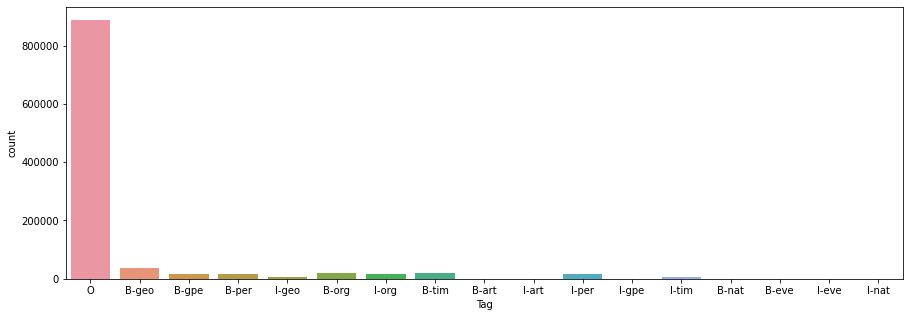

In [7]:
#Countplot
plt.figure(figsize=(15,5))
sns.countplot(x="Tag", data=data)
plt.show()

Observation: From the above count plot it can be obserbed that most of the tags are 'O' that is the word is not of interest

In [8]:
# Count of words with corresponding tag
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [9]:
data.isnull().sum(axis = 0)

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

Observation: It can be observed that there are no missing values in the data

In [10]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print("Number of unique words in dataset:", n_words)

Number of unique words in dataset: 35169


In [11]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 17


In [12]:
#To get a sentence
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    

In [13]:
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [14]:
print("Number of sentences in dataset:", len(sentences))
maxlen = max([len(s) for s in sentences])
print ('Maximum sentence length:', maxlen)

Number of sentences in dataset: 47959
Maximum sentence length: 104


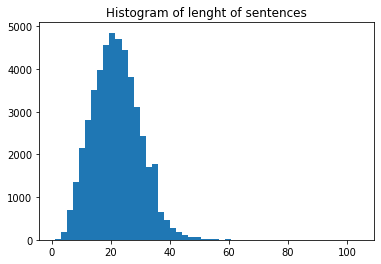

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title("Histogram of lenght of sentences")
plt.show()

In [16]:
#Words with B-org tag
data.loc[data['Tag'] == 'B-org', 'Word'].head()

97             Labor
154    International
215             IAEA
234         European
248             U.N.
Name: Word, dtype: object

In [17]:
#Words with I-org tag
data.loc[data['Tag'] == 'I-org', 'Word'].head()

98      Party
155    Atomic
156    Energy
157    Agency
235     Union
Name: Word, dtype: object

# 3.Data Pre-processing

In [18]:
# Assigning index to all unique words and tags
max_len = 100
word_to_idx = {w: i + 1 for i, w in enumerate(words)}
tag_to_idx = {t: i for i, t in enumerate(tags)}
# word_to_idx
tag_to_idx

{'B-art': 9,
 'B-eve': 4,
 'B-geo': 8,
 'B-gpe': 5,
 'B-nat': 2,
 'B-org': 3,
 'B-per': 15,
 'B-tim': 1,
 'I-art': 6,
 'I-eve': 14,
 'I-geo': 11,
 'I-gpe': 10,
 'I-nat': 12,
 'I-org': 7,
 'I-per': 16,
 'I-tim': 0,
 'O': 13}

In [19]:
# Convert the sentence with words to sentence with corresponding index to each word
X = [[word_to_idx[w[0]] for w in s ] for s in sentences]
# Padding sentences to make the length of all sentences same
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
X[0]

array([24538,  6930,  1371, 18610, 12810,  1021, 30886, 13380, 31421,
        2636, 29352, 11510, 29740,  1210, 12850,  2636, 16988,  6930,
       15182, 26911, 17385, 33899, 25264, 10484,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [20]:
# Converting tags to indices
y = [[tag_to_idx[w[2]] for w in s] for s in sentences]
# Padding tags to match length of sentence
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag_to_idx["O"])
# Make y categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [21]:
X.shape

(47959, 100)

In [22]:
len(y)
y=np.array(y)
y.shape
print(y[0].shape)

(100, 17)


In [23]:
# Splitting data into train data (80%) and test data (20%)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
print(X_tr.shape)
y_tr=np.array(y_tr)
print(y_tr.shape)
print(X_tr)

(38367, 100)
(38367, 100, 17)
[[24174 31060  2636 ...     0     0     0]
 [ 8634  2596 22930 ...     0     0     0]
 [28370 22706  1313 ...     0     0     0]
 ...
 [16127 16378  7610 ...     0     0     0]
 [21137 10619   977 ...     0     0     0]
 [ 2494  3340   717 ...     0     0     0]]


# 4. Training the Model

In [24]:
# Defining model architecture

tf.compat.v1.set_random_seed(32)

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20, input_length=max_len)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(n_tags, learn_mode = 'join', test_mode = 'viterbi') 
out = crf(model)  

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [26]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf_loss, metrics=[crf_viterbi_accuracy,f1_m,precision_m, recall_m])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 20)           703400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 17)           1190      
Total params: 738,040
Trainable params: 738,040
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Train the model
history = model.fit(X_tr, np.array(y_tr), batch_size=64, epochs=6, validation_split=0.2, verbose=1)


Train on 30693 samples, validate on 7674 samples
Epoch 1/6
30693/30693 [==============================] - 86s 3ms/step - loss: 0.1371 - crf_viterbi_accuracy: 0.9628 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0538 - val_crf_viterbi_accuracy: 0.9822 - val_f1_m: 0.9822 - val_precision_m: 0.9822 - val_recall_m: 0.9822
Epoch 2/6
30693/30693 [==============================] - 84s 3ms/step - loss: 0.0350 - crf_viterbi_accuracy: 0.9867 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0220 - val_crf_viterbi_accuracy: 0.9894 - val_f1_m: 0.9894 - val_precision_m: 0.9894 - val_recall_m: 0.9894
Epoch 3/6
30693/30693 [==============================] - 81s 3ms/step - loss: 0.0129 - crf_viterbi_accuracy: 0.9913 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0101 - val_crf_viterbi_accuracy: 0.9908 - val_f1_m: 0.9908 - val_precision_m: 0.9908 - val_recall_m: 0.9908
Epoch 4/6
30693/30693 [=========

In [28]:
hist = pd.DataFrame(history.history)
hist

val_loss  val_crf_viterbi_accuracy  val_f1_m  val_precision_m  \
0  0.053776                  0.982195  0.982195         0.982195   
1  0.022006                  0.989436  0.989436         0.989436   
2  0.010083                  0.990820  0.990820         0.990820   
3  0.002115                  0.991829  0.991829         0.991829   
4 -0.003842                  0.992134  0.992134         0.992134   
5 -0.009943                  0.992348  0.992348         0.992348   

   val_recall_m      loss  crf_viterbi_accuracy  f1_m  precision_m  recall_m  
0      0.982195  0.137116              0.962838   0.0          0.0       0.0  
1      0.989436  0.035027              0.986746   0.0          0.0       0.0  
2      0.990820  0.012852              0.991332   0.0          0.0       0.0  
3      0.991829  0.002493              0.992839   0.0          0.0       0.0  
4      0.992134 -0.004861              0.993549   0.0          0.0       0.0  
5      0.992348 -0.011305              0.994037   0.0          0.0       0.0

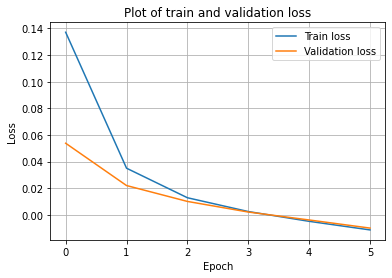

In [29]:
plt.plot(hist["loss"], label="Train loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Plot of train and validation loss")
plt.grid()
plt.show()

Observation: As both train and validation loss converge, we can conclude that the model is best fit.

# 5. Evaluate the Model

In [30]:
# Predict output for test data
test_pred = model.predict(X_te, verbose=1)
# Index as key and tag as value
idx_to_tag = {i: w for w, i in tag_to_idx.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx_to_tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

print("Accuracy: ", accuracy_score(test_labels, pred_labels))

9592/9592 [==============================] - 10s 1ms/step
Accuracy:  0.9925990408673895


# 6. Results

In [76]:
# Output for random test input
i = 1500
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
    
x = PrettyTable()
x.field_names = ["Word", "Actual Tag", "Predicted Tag"]

for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        x.add_row([words[w-1], tags[t], tags[pred]])
        
print(x)


+-------------+------------+---------------+
|     Word    | Actual Tag | Predicted Tag |
+-------------+------------+---------------+
|      He     |     O      |       O       |
|     said    |     O      |       O       |
|    there    |     O      |       O       |
|     were    |     O      |       O       |
|      no     |     O      |       O       |
|    Dutch    |   B-gpe    |     B-gpe     |
|  casualties |     O      |       O       |
|      in     |     O      |       O       |
|     the     |     O      |       O       |
|   fighting  |     O      |       O       |
|    which    |     O      |       O       |
|   occurred  |     O      |       O       |
|    after    |     O      |       O       |
|  militants  |     O      |       O       |
|     set     |     O      |       O       |
|      up     |     O      |       O       |
|  positions  |     O      |       O       |
|      in     |     O      |       O       |
|     the     |     O      |       O       |
|    hills

In [32]:
# Query sentence other than test input
test_sentence = ["India", "is", "second", "most", "populous", "country"]

In [33]:
x_test_sent = pad_sequences(sequences=[[word_to_idx.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

In [34]:
# Output tags for query input
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)

x = PrettyTable()
x.field_names = ["Word", "Predicted Tag"]

for w, pred in zip(test_sentence, p[0]):
    x.add_row([w, tags[pred]])
        
print(x)

+----------+---------------+
|   Word   | Predicted Tag |
+----------+---------------+
|  India   |     B-geo     |
|    is    |       O       |
|  second  |       O       |
|   most   |       O       |
| populous |       O       |
| country  |       O       |
+----------+---------------+


In [58]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=b0c12f6545915d27172820e5206a9991779f5aa406b0c207636cdcd5ace3c229
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [97]:
from future.utils import iteritems
tags = list(set(data["Tag"].values))
number_tags = len(tags)

tag2idx = {t: i+1 for i, t in enumerate(tags)}
idx2tag = {i: w for w, i in iteritems(tag2idx)}

In [98]:
#Evaluating the model
from sklearn.metrics import classification_report
y_pred = model.predict(np.array(X_te))  
print(classification_report(np.argmax(y_te, 2).ravel(), 
                            np.argmax(y_pred, axis=2).ravel(),
                            labels=list(idx2tag.keys()), 
                            target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

       I-tim       0.91      0.88      0.90      4013
       B-tim       0.00      0.00      0.00        53
       B-nat       0.77      0.69      0.73      4072
       B-org       1.00      0.04      0.07        54
       B-eve       0.97      0.92      0.94      3189
       B-gpe       0.00      0.00      0.00        58
       I-art       0.77      0.75      0.76      3499
       I-org       0.85      0.88      0.86      7454
       B-geo       0.00      0.00      0.00        77
       B-art       0.96      0.59      0.73        41
       I-gpe       0.78      0.78      0.78      1478
       I-geo       0.00      0.00      0.00        13
       I-nat       1.00      1.00      1.00    926713
           O       1.00      0.02      0.04        51
       I-eve       0.81      0.83      0.82      3513
       B-per       0.82      0.91      0.87      3587
       I-per       0.00      0.00      0.00         0

   micro avg       0.99   

# 7. Conclusion

1. Bi-LSTM-CRF model is used for NER task. 
2. Here join mode is used as learning mode with vertibri algorithm which gives best path as prediction result but not softmax. Hence custom loss and accuracy that is crf_loss and crf_viterbi_accuracy respectively are used.
3. Model is trained on train data. Plot of train and validation loss shows that the model is best fit.
4. Model is evaluated on test data.The accuracy of model after evaluation is 99.2%
5. Model is tested on un-known data, and the result is satisfactory
